- Usa ARIMA si tienes una serie temporal no estacional que presenta tendencia.
- Usa SARIMA si tienes datos estacionales con tendencias.
- Considera modelos derivados (ARIMAX, SARIMAX) si tienes variables externas que podrían afectar la serie temporal que estás modelando.

In [1]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from skforecast.model_selection import bayesian_search_forecaster

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.model_selection import train_test_split
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skforecast.model_selection import backtesting_forecaster
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

from astral import LocationInfo
from astral.sun import sun
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from skforecast.model_selection import select_features
from skforecast.plot import plot_residuals
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

c:\Users\HP\miniconda3\envs\Forecasting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versión skforecast: 0.13.0
Versión pdarima: 2.0.4
Versión statsmodels: 0.14.2
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [3]:
# Cargar el dataset
df = pd.read_excel('../dataset/atm_historical_data_with_features.xlsx')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by=['ATM_ID', 'Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3580 entries, 0 to 3579
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      3580 non-null   datetime64[ns]
 1   ATM_ID                    3580 non-null   int64         
 2   Agency                    3580 non-null   object        
 3   Day_of_Week               3580 non-null   object        
 4   Soles_Withdrawn           3580 non-null   int64         
 5   Dollars_Withdrawn         3580 non-null   int64         
 6   Event                     2698 non-null   object        
 7   Holiday                   3580 non-null   int64         
 8   Supply_Cost_Fixed         3580 non-null   int64         
 9   Supply_Cost_Variable      3580 non-null   float64       
 10  ATM_Max_Capacity_Soles    3580 non-null   int64         
 11  ATM_Max_Capacity_Dollars  3580 non-null   int64         
 12  Opportunity_Cost    

In [4]:
# Comprobar la presencia de valores nulos
print(df.isnull().sum())

Date                          0
ATM_ID                        0
Agency                        0
Day_of_Week                   0
Soles_Withdrawn               0
Dollars_Withdrawn             0
Event                       882
Holiday                       0
Supply_Cost_Fixed             0
Supply_Cost_Variable          0
ATM_Max_Capacity_Soles        0
ATM_Max_Capacity_Dollars      0
Opportunity_Cost              0
Soles_Withdrawn_Lag1          0
Dollars_Withdrawn_Lag1        0
Soles_Withdrawn_Lag7          0
Dollars_Withdrawn_Lag7        0
Soles_Moving_Avg_7            0
Dollars_Moving_Avg_7          0
Total_Withdrawn               0
Total_Withdrawn_Lag1          0
Total_Withdrawn_Lag7          0
Total_Moving_Avg_7            0
dtype: int64


In [78]:
# Seleccionar las columnas de interés para el modelado
#features = [
#    'Soles_Withdrawn_Lag1', 'Dollars_Withdrawn_Lag1',
#    'Soles_Withdrawn_Lag7', 'Dollars_Withdrawn_Lag7',
#    'Soles_Moving_Avg_7', 'Dollars_Moving_Avg_7',
#    'Total_Withdrawn_Lag1', 'Total_Withdrawn_Lag7',
#    'Total_Moving_Avg_7', 'Holiday'
#]

In [5]:
#X = df[features]
y_soles = df['Soles_Withdrawn']
y_dollars = df['Dollars_Withdrawn']

# Calcular el índice de división
fin_train = int(len(df) * 0.8)
fin_validacion = fin_train + int(len(df) * 0.1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train = df.iloc[:fin_train]
X_val = df.iloc[fin_train:fin_validacion, :]
X_test = df.iloc[fin_validacion:, :]
y_soles_train = y_soles.iloc[:fin_train]
y_soles_val = y_soles.iloc[:fin_validacion]
y_soles_test = y_soles.iloc[fin_validacion:]

print(
    f"Fechas train      : {X_train.index.min()} --- {X_train.index.max()}  "
    f"(n={len(X_train)})"
)
print(
    f"Fechas validación : {X_val.index.min()} --- {X_val.index.max()}  "
    f"(n={len(X_val)})"
)
print(
    f"Fechas test       : {X_test.index.min()} --- {X_test.index.max()}  "
    f"(n={len(X_test)})"
)

Fechas train      : 0 --- 2863  (n=2864)
Fechas validación : 2864 --- 3221  (n=358)
Fechas test       : 3222 --- 3579  (n=358)


In [6]:
# Gráfico interactivo de la serie temporal
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_train.index, y=X_train['Soles_Withdrawn'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=X_val.index, y=X_val['Soles_Withdrawn'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=X_test.index, y=X_test['Soles_Withdrawn'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Monto de transacciones en soles',
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    legend_title="Partición:",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


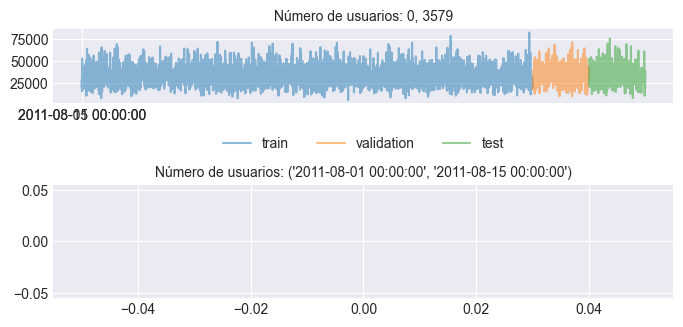

In [81]:
# Gráfico de la serie temporal con zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

X_train['Soles_Withdrawn'].plot(ax=main_ax, label='train', alpha=0.5)
X_val['Soles_Withdrawn'].plot(ax=main_ax, label='validation', alpha=0.5)
X_test['Soles_Withdrawn'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(df['Soles_Withdrawn'])
max_y = max(df['Soles_Withdrawn'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
df.loc[zoom[0]: zoom[1]]['Soles_Withdrawn'].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Número de usuarios: {df.index.min()}, {df.index.max()}', fontsize=10)
zoom_ax.set_title(f'Número de usuarios: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

In [82]:
df.columns

Index(['Date', 'ATM_ID', 'Agency', 'Day_of_Week', 'Soles_Withdrawn',
       'Dollars_Withdrawn', 'Event', 'Holiday', 'Supply_Cost_Fixed',
       'Supply_Cost_Variable', 'ATM_Max_Capacity_Soles',
       'ATM_Max_Capacity_Dollars', 'Opportunity_Cost', 'Soles_Withdrawn_Lag1',
       'Dollars_Withdrawn_Lag1', 'Soles_Withdrawn_Lag7',
       'Dollars_Withdrawn_Lag7', 'Soles_Moving_Avg_7', 'Dollars_Moving_Avg_7',
       'Total_Withdrawn', 'Total_Withdrawn_Lag1', 'Total_Withdrawn_Lag7',
       'Total_Moving_Avg_7'],
      dtype='object')

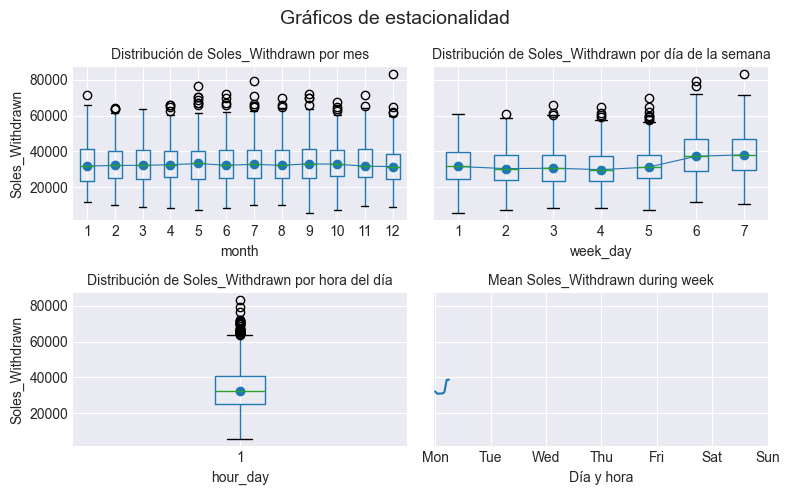

In [83]:
# Estacionalidad anual, semanal y diaria
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Distribusión de usuarios por mes
df['month'] = df['Date'].dt.month
df.boxplot(column='Soles_Withdrawn', by='month', ax=axs[0])
df.groupby('month')['Soles_Withdrawn'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Soles_Withdrawn')
axs[0].set_title('Distribución de Soles_Withdrawn por mes', fontsize=10)

# Distribusión de usuarios por día de la semana
df['week_day'] = df['Date'].dt.day_of_week + 1
df.boxplot(column='Soles_Withdrawn', by='week_day', ax=axs[1])
df.groupby('week_day')['Soles_Withdrawn'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Soles_Withdrawn')
axs[1].set_title('Distribución de Soles_Withdrawn por día de la semana', fontsize=10)

# Distribusión de usuarios por hora del día
df['hour_day'] = df['Date'].dt.hour + 1
df.boxplot(column='Soles_Withdrawn', by='hour_day', ax=axs[2])
df.groupby('hour_day')['Soles_Withdrawn'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Soles_Withdrawn')
axs[2].set_title('Distribución de Soles_Withdrawn por hora del día', fontsize=10)

# Distribusión de usuarios por día de la semana y hora del día
mean_day_hour = df.groupby(["week_day", "hour_day"])["Soles_Withdrawn"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean Soles_Withdrawn during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Día y hora",
    ylabel      = "Users"
)
axs[3].title.set_size(10)

fig.suptitle("Gráficos de estacionalidad", fontsize=14)
fig.tight_layout()

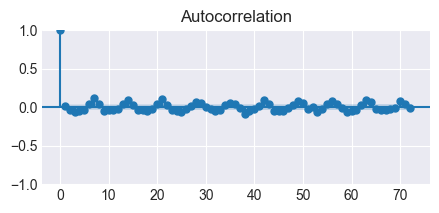

In [84]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(df['Soles_Withdrawn'], ax=ax, lags=72)
plt.show()

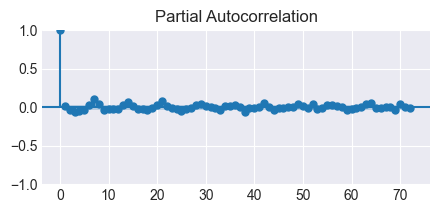

In [85]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(df['Soles_Withdrawn'], ax=ax, lags=72, method='ywm')
plt.show()

In [86]:
df.loc[:fin_validacion, 'Soles_Withdrawn']

0       20475
1       29123
2       15459
3       53289
4       30505
        ...  
3218    28549
3219    38785
3220    42705
3221    37963
3222    50346
Name: Soles_Withdrawn, Length: 3223, dtype: int64

In [87]:
y_soles_train

0       20475
1       29123
2       15459
3       53289
4       30505
        ...  
3217    27727
3218    28549
3219    38785
3220    42705
3221    37963
Name: Soles_Withdrawn, Length: 3222, dtype: int64

In [90]:
# Crear un baseline: valor de la misma hora del día anterior
# ==============================================================================
#forecaster = ForecasterEquivalentDate(
#    offset    = pd.DateOffset(days=1),
#    n_offsets = 1
#)
#
## Entremaiento del forecaster
## ==============================================================================
#df.set_index('Date', inplace=True)
#y_soles_train = df.loc[:'2023-01-08', 'Soles_Withdrawn']
#forecaster.fit(y=y_soles_train)
#forecaster

In [91]:
# Crear el forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=15926, verbose=-1),
    lags      = 24
)
# Entrenar el forecaster
# ==============================================================================
forecaster.fit(y_soles_train)
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [0, 3221] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-09-27 01:13:08 
Last fit date: 2024-09-27 01:13:08 
Skforecast version

In [92]:
forecaster.predict(steps=10)

3222    27868.975910
3223    31338.186020
3224    32459.950681
3225    31552.298926
3226    29677.079984
3227    39063.039782
3228    42279.160115
3229    33827.816293
3230    30776.469621
3231    32190.787450
Name: pred, dtype: float64

In [93]:
# Backtest del modelo con los datos de test
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = y_soles,
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(y_soles_train),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = True, # Cambiar a False para mostrar menos información
    show_progress      = True
)
predicciones.head()  # Muestra las primeras filas de las predicciones

Information of backtesting process
----------------------------------
Number of observations used for initial training: 3222
Number of observations used for backtesting: 358
    Number of folds: 10
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 34 observations.

Fold: 0
    Training:   0 -- 3221  (n=3222)
    Validation: 3222 -- 3257  (n=36)
Fold: 1
    Training:   No training in this fold
    Validation: 3258 -- 3293  (n=36)
Fold: 2
    Training:   No training in this fold
    Validation: 3294 -- 3329  (n=36)
Fold: 3
    Training:   No training in this fold
    Validation: 3330 -- 3365  (n=36)
Fold: 4
    Training:   No training in this fold
    Validation: 3366 -- 3401  (n=36)
Fold: 5
    Training:   No training in this fold
    Validation: 3402 -- 3437  (n=36)
Fold: 6
    Training:   No training in this fold
    Validation: 3438 -- 3473  (n=36)
Fold: 7
    Tr

  0%|          | 0/10 [00:00<?, ?it/s]

,pred
3222,27868.975910
3223,31338.186020
3224,32459.950681
3225,31552.298926
3226,29677.079984


In [94]:
metrica

,mean_absolute_error
0,9503.596427


In [98]:
# Búsqueda de hiperparámetros
# ==============================================================================
# Lags candidatos
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

resultados_busqueda, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = y_soles.iloc[:fin_validacion], # Datos test no incluidos
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(X_train),
    fixed_train_size   = False,
    n_trials           = 20, # Aumentar para una búsqueda más exhaustiva
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'n_estimators': 400, 'max_depth': 10, 'min_data_in_leaf': 483, 'learning_rate': 0.01498757536839336, 'feature_fraction': 0.5, 'max_bin': 50, 'reg_alpha': 0.9, 'reg_lambda': 0.2}
  Backtesting metric: 9306.210496004627



In [99]:
# Resultados de la búsqueda
# ==============================================================================
resultados_busqueda.head(10)

,lags,params,mean_absolute_error,n_estimators,max_depth,min_data_in_leaf,learning_rate,feature_fraction,max_bin,reg_alpha,reg_lambda
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 400, 'max_depth': 10, 'min_da...",9306.210496,400.0,10.0,483.0,0.014988,0.5,50.0,0.9,0.2
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 400, 'max_depth': 10, 'min_da...",9318.441122,400.0,10.0,492.0,0.013950,0.5,50.0,0.9,0.2
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 400, 'max_depth': 10, 'min_da...",9321.084625,400.0,10.0,488.0,0.010019,0.6,50.0,1.0,0.0
14,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 400, 'max_depth': 9, 'min_dat...",9388.043284,400.0,9.0,435.0,0.011969,0.5,50.0,0.9,0.3
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 400, 'max_depth': 10, 'min_da...",9472.630765,400.0,10.0,487.0,0.092113,0.6,50.0,0.8,0.2
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 700, 'max_depth': 7, 'min_dat...",9484.749671,700.0,7.0,342.0,0.061895,0.5,100.0,0.7,0.9
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 800, 'max_depth': 9, 'min_dat...",9567.234080,800.0,9.0,429.0,0.058142,0.5,125.0,1.0,0.4
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 600, 'max_depth': 8, 'min_dat...",9608.659623,600.0,8.0,437.0,0.114414,0.6,100.0,0.8,0.1
19,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 800, 'max_depth': 10, 'min_da...",9662.662859,800.0,10.0,419.0,0.055547,0.5,150.0,0.3,0.2
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 7, 'min_da...",9989.441447,1000.0,7.0,368.0,0.168250,0.7,100.0,0.3,0.6


In [100]:
# Mejor modelo
# ==============================================================================
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(feature_fraction=0.5, learning_rate=0.01498757536839336,
              max_bin=50, max_depth=10, min_data_in_leaf=483, n_estimators=400,
              random_state=15926, reg_alpha=0.9, reg_lambda=0.2, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
Transformer for y: None 
Transformer for exog: None 
Window size: 72 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [0, 3221] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01498757536839336, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'mi

In [101]:
# Backtest modelo final con datos de test
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = y_soles,
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(y_soles_train),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = True, # Cambiar a False para mostrar menos información
    show_progress      = True
)
display(metrica)
predicciones.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 3222
Number of observations used for backtesting: 358
    Number of folds: 10
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 34 observations.

Fold: 0
    Training:   0 -- 3221  (n=3222)
    Validation: 3222 -- 3257  (n=36)
Fold: 1
    Training:   No training in this fold
    Validation: 3258 -- 3293  (n=36)
Fold: 2
    Training:   No training in this fold
    Validation: 3294 -- 3329  (n=36)
Fold: 3
    Training:   No training in this fold
    Validation: 3330 -- 3365  (n=36)
Fold: 4
    Training:   No training in this fold
    Validation: 3366 -- 3401  (n=36)
Fold: 5
    Training:   No training in this fold
    Validation: 3402 -- 3437  (n=36)
Fold: 6
    Training:   No training in this fold
    Validation: 3438 -- 3473  (n=36)
Fold: 7
    Tr

  0%|          | 0/10 [00:00<?, ?it/s]

,mean_absolute_error
0,9297.939351


,pred
3222,33750.301926
3223,33027.901513
3224,31838.735082
3225,30112.647740
3226,35549.953904


In [102]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=X_test.index, y=X_test['Soles_Withdrawn'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="Predicción",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [104]:
import pandas as pd
import numpy as np
from astral.sun import sun
from astral.geocoder import database, lookup
from astral import LocationInfo

# Variables basadas en el calendario
# ==============================================================================
df = df.reset_index()
variables_calendario = pd.DataFrame(df['Date'])
variables_calendario['mes'] = variables_calendario['Date'].dt.month
variables_calendario['semana_anyo'] = variables_calendario['Date'].dt.isocalendar().week
variables_calendario['dia_semana'] = variables_calendario['Date'].dt.day_of_week + 1
variables_calendario['day_of_Year'] = variables_calendario['Date'].dt.dayofyear
variables_calendario['hora_dia'] = variables_calendario['Date'].dt.hour + 1

# Variables basadas en la luz solar
# ==============================================================================
location = LocationInfo(
    name='Washington DC',
    region='USA',
    timezone='US/Eastern',
    latitude=40.516666666666666,
    longitude=-77.03333333333333
)

# Asegurarse de iterar sobre las fechas reales
hora_amanecer = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in variables_calendario['Date']
]
hora_anochecer = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in variables_calendario['Date']
]

variables_solares = pd.DataFrame({
    'hora_amanecer': hora_amanecer,
    'hora_anochecer': hora_anochecer
}, index=variables_calendario.index)

variables_solares['horas_luz_solar'] = (
    variables_solares['hora_anochecer'] - variables_solares['hora_amanecer']
)
variables_solares["es_de_dia"] = np.where(
    (df['Date'].dt.hour >= variables_solares["hora_amanecer"])
    & (df['Date'].dt.hour < variables_solares["hora_anochecer"]),
    1,
    0,
)

# Merge all exogenous variables
# ==============================================================================
variables_exogenas = pd.concat([
    variables_calendario,
    variables_solares,
], axis=1)

variables_exogenas.head(4)

,Date,mes,semana_anyo,dia_semana,day_of_Year,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia
0,2023-01-08,1,1,7,8,1,7,16,9,0
1,2023-01-09,1,2,1,9,1,7,16,9,0
2,2023-01-10,1,2,2,10,1,7,17,10,0
3,2023-01-11,1,2,3,11,1,7,17,10,0


In [105]:
# Codificación cíclica de las variables de calendario y luz solar
# ==============================================================================
def codificacion_ciclica(datos: pd.Series, longitud_ciclo: int) -> pd.DataFrame:
    """
    Codifica una variable cíclica con dos nuevas variables: seno y coseno.
    Se asume que el valor mínimo de la variable es 0. El valor máximo de la
    variable se pasa como argumento.
      
    Parameters
    ----------
    datos : pd.Series
        Serie con la variable a codificar.
    longitud_ciclo : int
        La longitud del ciclo. Por ejemplo, 12 para meses, 24 para horas, etc.
        Este valor se utiliza para calcular el ángulo del seno y coseno.

    Returns
    -------
    resultado : pd.DataFrame
        Dataframe con las dos nuevas características: seno y coseno.

    """

    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({
                  f"{datos.name}_seno": seno,
                  f"{datos.name}_coseno": coseno
              })

    return resultado


mes_encoded = codificacion_ciclica(variables_exogenas['mes'], longitud_ciclo=12)
semana_anyo_encoded = codificacion_ciclica(variables_exogenas['semana_anyo'], longitud_ciclo=52)
dia_semana_encoded = codificacion_ciclica(variables_exogenas['dia_semana'], longitud_ciclo=7)
hora_amanecer_encoded = codificacion_ciclica(variables_exogenas['hora_amanecer'], longitud_ciclo=24)
hora_anochecer_encoded = codificacion_ciclica(variables_exogenas['hora_anochecer'], longitud_ciclo=24)
hora_dia_encoded = codificacion_ciclica(variables_exogenas['hora_dia'], longitud_ciclo=24)

variables_ciclicas = pd.concat([
                            mes_encoded,
                            semana_anyo_encoded,
                            dia_semana_encoded,
                            hora_dia_encoded,
                            hora_amanecer_encoded,
                            hora_anochecer_encoded
                        ], axis=1)  

variables_exogenas = pd.concat([variables_exogenas, variables_ciclicas], axis=1)
variables_exogenas.head(3)

,Date,mes,semana_anyo,dia_semana,day_of_Year,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,...,semana_anyo_seno,semana_anyo_coseno,dia_semana_seno,dia_semana_coseno,hora_dia_seno,hora_dia_coseno,hora_amanecer_seno,hora_amanecer_coseno,hora_anochecer_seno,hora_anochecer_coseno
0,2023-01-08,1,1,7,8,1,7,16,9,0,...,0.120537,0.992709,-2.449294e-16,1.000000,0.258819,0.965926,0.965926,-0.258819,-0.866025,-0.500000
1,2023-01-09,1,2,1,9,1,7,16,9,0,...,0.239316,0.970942,7.818315e-01,0.623490,0.258819,0.965926,0.965926,-0.258819,-0.866025,-0.500000
2,2023-01-10,1,2,2,10,1,7,17,10,0,...,0.239316,0.970942,9.749279e-01,-0.222521,0.258819,0.965926,0.965926,-0.258819,-0.965926,-0.258819


In [106]:
print(variables_exogenas.columns)

Index(['Date', 'mes', 'semana_anyo', 'dia_semana', 'day_of_Year', 'hora_dia',
       'hora_amanecer', 'hora_anochecer', 'horas_luz_solar', 'es_de_dia',
       'mes_seno', 'mes_coseno', 'semana_anyo_seno', 'semana_anyo_coseno',
       'dia_semana_seno', 'dia_semana_coseno', 'hora_dia_seno',
       'hora_dia_coseno', 'hora_amanecer_seno', 'hora_amanecer_coseno',
       'hora_anochecer_seno', 'hora_anochecer_coseno'],
      dtype='object')


In [107]:
# Interacción entre variables exógenas
# ==============================================================================
transformer_poly = PolynomialFeatures(
    degree           = 2,
    interaction_only = True,
    include_bias     = False
).set_output(transform="pandas")

poly_cols = [
    'mes_seno',
    'mes_coseno',
    'semana_anyo_seno',
    'semana_anyo_coseno',
    'dia_semana_seno',
    'dia_semana_coseno',
    'hora_dia_seno',
    'hora_dia_coseno',
    'hora_amanecer_seno',
    'hora_amanecer_coseno',
    'hora_anochecer_seno',
    'hora_anochecer_coseno',
    'horas_luz_solar',
    'es_de_dia',
]

variables_poly = transformer_poly.fit_transform(variables_exogenas[poly_cols].dropna())
variables_poly = variables_poly.drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
variables_exogenas = pd.concat([variables_exogenas, variables_poly], axis=1)
variables_exogenas.head(3)

,Date,mes,semana_anyo,dia_semana,day_of_Year,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,...,poly_hora_amanecer_coseno__hora_anochecer_seno,poly_hora_amanecer_coseno__hora_anochecer_coseno,poly_hora_amanecer_coseno__horas_luz_solar,poly_hora_amanecer_coseno__es_de_dia,poly_hora_anochecer_seno__hora_anochecer_coseno,poly_hora_anochecer_seno__horas_luz_solar,poly_hora_anochecer_seno__es_de_dia,poly_hora_anochecer_coseno__horas_luz_solar,poly_hora_anochecer_coseno__es_de_dia,poly_horas_luz_solar__es_de_dia
0,2023-01-08,1,1,7,8,1,7,16,9,0,...,0.224144,0.129410,-2.329371,-0.0,0.433013,-7.794229,-0.0,-4.50000,-0.0,0.0
1,2023-01-09,1,2,1,9,1,7,16,9,0,...,0.224144,0.129410,-2.329371,-0.0,0.433013,-7.794229,-0.0,-4.50000,-0.0,0.0
2,2023-01-10,1,2,2,10,1,7,17,10,0,...,0.250000,0.066987,-2.588190,-0.0,0.250000,-9.659258,-0.0,-2.58819,-0.0,0.0


In [108]:
# Codificación cíclica de las variables de calendario y luz solar
# ==============================================================================
def codificacion_ciclica(datos: pd.Series, longitud_ciclo: int) -> pd.DataFrame:
    """
    Codifica una variable cíclica con dos nuevas variables: seno y coseno.
    Se asume que el valor mínimo de la variable es 0. El valor máximo de la
    variable se pasa como argumento.
      
    Parameters
    ----------
    datos : pd.Series
        Serie con la variable a codificar.
    longitud_ciclo : int
        La longitud del ciclo. Por ejemplo, 12 para meses, 24 para horas, etc.
        Este valor se utiliza para calcular el ángulo del seno y coseno.

    Returns
    -------
    resultado : pd.DataFrame
        Dataframe con las dos nuevas características: seno y coseno.

    """

    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({
                  f"{datos.name}_seno": seno,
                  f"{datos.name}_coseno": coseno
              })

    return resultado


mes_encoded = codificacion_ciclica(variables_exogenas['mes'], longitud_ciclo=12)
semana_anyo_encoded = codificacion_ciclica(variables_exogenas['semana_anyo'], longitud_ciclo=52)
dia_semana_encoded = codificacion_ciclica(variables_exogenas['dia_semana'], longitud_ciclo=7)
hora_dia_encoded = codificacion_ciclica(variables_exogenas['hora_dia'], longitud_ciclo=24)
hora_amanecer_encoded = codificacion_ciclica(variables_exogenas['hora_amanecer'], longitud_ciclo=24)
hora_anochecer_encoded = codificacion_ciclica(variables_exogenas['hora_anochecer'], longitud_ciclo=24)

variables_ciclicas = pd.concat([
                            mes_encoded,
                            semana_anyo_encoded,
                            dia_semana_encoded,
                            hora_dia_encoded,
                            hora_amanecer_encoded,
                            hora_anochecer_encoded
                        ], axis=1)  

variables_exogenas = pd.concat([variables_exogenas, variables_ciclicas], axis=1)
variables_exogenas.head(3)

,Date,mes,semana_anyo,dia_semana,day_of_Year,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,...,semana_anyo_seno,semana_anyo_coseno,dia_semana_seno,dia_semana_coseno,hora_dia_seno,hora_dia_coseno,hora_amanecer_seno,hora_amanecer_coseno,hora_anochecer_seno,hora_anochecer_coseno
0,2023-01-08,1,1,7,8,1,7,16,9,0,...,0.120537,0.992709,-2.449294e-16,1.000000,0.258819,0.965926,0.965926,-0.258819,-0.866025,-0.500000
1,2023-01-09,1,2,1,9,1,7,16,9,0,...,0.239316,0.970942,7.818315e-01,0.623490,0.258819,0.965926,0.965926,-0.258819,-0.866025,-0.500000
2,2023-01-10,1,2,2,10,1,7,17,10,0,...,0.239316,0.970942,9.749279e-01,-0.222521,0.258819,0.965926,0.965926,-0.258819,-0.965926,-0.258819


In [109]:
# Interacción entre variables exógenas
# ==============================================================================
transformer_poly = PolynomialFeatures(
    degree           = 2,
    interaction_only = True,
    include_bias     = False
).set_output(transform="pandas")

poly_cols = [
    'mes_seno',
    'mes_coseno',
    'semana_anyo_seno',
    'semana_anyo_coseno',
    'dia_semana_seno',
    'dia_semana_coseno',
    'hora_dia_seno',
    'hora_dia_coseno',
    'hora_amanecer_seno',
    'hora_amanecer_coseno',
    'hora_anochecer_seno',
    'hora_anochecer_coseno',
    'horas_luz_solar',
    'es_de_dia',
]

variables_poly = transformer_poly.fit_transform(variables_exogenas[poly_cols].dropna())
variables_poly = variables_poly.drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
variables_exogenas = pd.concat([variables_exogenas, variables_poly], axis=1)
variables_exogenas.head(3)

,Date,mes,semana_anyo,dia_semana,day_of_Year,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,...,poly_hora_anochecer_seno__hora_anochecer_coseno,poly_hora_anochecer_seno__hora_anochecer_coseno,poly_hora_anochecer_seno__horas_luz_solar,poly_hora_anochecer_seno__es_de_dia,poly_hora_anochecer_coseno__hora_anochecer_coseno,poly_hora_anochecer_coseno__horas_luz_solar,poly_hora_anochecer_coseno__es_de_dia,poly_hora_anochecer_coseno__horas_luz_solar,poly_hora_anochecer_coseno__es_de_dia,poly_horas_luz_solar__es_de_dia
0,2023-01-08,1,1,7,8,1,7,16,9,0,...,0.433013,0.433013,-7.794229,-0.0,0.250000,-4.50000,-0.0,-4.50000,-0.0,0.0
1,2023-01-09,1,2,1,9,1,7,16,9,0,...,0.433013,0.433013,-7.794229,-0.0,0.250000,-4.50000,-0.0,-4.50000,-0.0,0.0
2,2023-01-10,1,2,2,10,1,7,17,10,0,...,0.250000,0.250000,-9.659258,-0.0,0.066987,-2.58819,-0.0,-2.58819,-0.0,0.0


In [110]:
# Transformación con codificación one-hot
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")  

In [111]:
# Crear un forecaster con un transformer para las variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = one_hot_encoder
)

In [112]:
# Mostrar matrices de entrenamiento
# ==============================================================================
exog_cols = ['weather']        
X_train, y_train = forecaster.create_train_X_y(
    y    = y_soles_train,
    exog = y_soles_train
)
X_train.head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,Soles_Withdrawn
72,29328.0,25758.0,29878.0,31878.0,33913.0,13815.0,41533.0,23325.0,49460.0,43320.0,...,33132.0,30592.0,17094.0,33692.0,30505.0,53289.0,15459.0,29123.0,20475.0,14043
73,14043.0,29328.0,25758.0,29878.0,31878.0,33913.0,13815.0,41533.0,23325.0,49460.0,...,29898.0,33132.0,30592.0,17094.0,33692.0,30505.0,53289.0,15459.0,29123.0,22689
74,22689.0,14043.0,29328.0,25758.0,29878.0,31878.0,33913.0,13815.0,41533.0,23325.0,...,36168.0,29898.0,33132.0,30592.0,17094.0,33692.0,30505.0,53289.0,15459.0,50294


In [113]:
# Transformación: codificación ordinal + conversión a tipo "category"
# ==============================================================================
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [114]:
# Crear un forecaster con detección automática de variables categóricas (LGBMRegressor)
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

In [115]:
# Selección de variables exógenas a incluir en el modelo
# ==============================================================================
exog_cols = []
# Columnas que terminan con _seno o _coseno son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='_seno$|_coseno$').columns.tolist())
# Columnas que empiezan con tem_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^temp_.*').columns.tolist())
# Columnas que empiezan con holiday_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^holiday_.*').columns.tolist())
exog_cols.extend(['temp', 'holiday', 'weather'])

variables_exogenas = variables_exogenas.filter(exog_cols, axis=1)

ValueError: cannot reindex on an axis with duplicate labels

In [116]:
# Combinar variables exógenas y target en el mismo dataframe
# ==============================================================================
datos = datos[['users', 'weather']].merge(
    variables_exogenas,
    left_index=True,
    right_index=True,
    how='left'
)

# Debido a la creación de medias móviles, hay valores NaN al principio de la serie.
# Debido a holiday_dia_siguiente hay valores NaN al final de la serie.
# Las columnas numéricas se convierten a float32.
datos = datos.dropna()
datos = datos.astype({col: np.float32 for col in datos.select_dtypes("number").columns})
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()
datos_test  = datos.loc[fin_validacion:, :].copy()

NameError: name 'datos' is not defined

In [118]:
# Búsqueda de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Lags grid
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = y_soles_train,
    exog               = y_soles_train,
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(X_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
best_params = results_search['params'].iat[0]

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1200, 'max_depth': 10, 'min_data_in_leaf': 25, 'learning_rate': 0.010018922062789044, 'feature_fraction': 1.0, 'max_bin': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
  Backtesting metric: 322.82041959155345



In [119]:
# Backtesting en los datos de test incluyendo las variables exógenas
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = y_soles,
    exog               = y_soles,
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(y_soles_train),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica

  0%|          | 0/10 [00:00<?, ?it/s]

,mean_absolute_error
0,420.334348


In [120]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=X_test.index, y=X_test['Soles_Withdrawn'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="Withdrawn",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [121]:
# Crear forecaster
# ==============================================================================
regressor = LGBMRegressor(
    n_estimators = 100,
    max_depth = 5,
    random_state = 15926,
    verbose = -1
)

forecaster = ForecasterAutoreg(
    regressor        = regressor,
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Eliminación recursiva de predictores con validación cruzada
# ==============================================================================
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 25,
    n_jobs                 = -1
)
lags_seleccionados, exog_seleccionadas = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = y_soles,
    exog            = y_soles,
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 123,
    verbose         = True,
)

d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2024-2\DataFest\env\Lib\site-packages\sklearn\feature_selection\_rfe.py:743: UserWarning:

Found min_features_to_select=25 > n_features=10. There will be no feature selection and all features will be kept.



Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 3411
Total number of records used for feature selection: 1705
Number of features available: 10
    Autoreg (n=9)
    Exog    (n=1)
Number of features selected: 10
    Autoreg (n=9) : [1, 2, 3, 23, 24, 25, 167, 168, 169]
    Exog    (n=1) : ['Soles_Withdrawn']


In [122]:
# Crear forecaster con los predictores seleccionados
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags             = lags_seleccionados,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Backtesting con los predictores seleccionados y los datos de test
# ==============================================================================
metrica_lgbm, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = y_soles,
    exog               = y_soles,
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(y_soles_train),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica_lgbm

  0%|          | 0/10 [00:00<?, ?it/s]

,mean_absolute_error
0,420.334348


In [123]:
# Actualizar las variables exógenas utilizadas
# ==============================================================================
exog_cols = exog_seleccionadas

In [124]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor          = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags               = 72,
    transformer_exog   = transformer_exog,
    fit_kwargs         = {"categorical_feature": "auto"},
    binner_kwargs      = {"n_bins": 15}
)
forecaster.fit(
    y    = y_soles_train,
    exog = y_train_soles
)

In [ ]:
# Predicción de intervalos
# ==============================================================================
# Como el modelo ha sido entrenado con variables exógenas, se tienen que pasar
# para las predicciones.
predictions = forecaster.predict_interval(
    exog     = y_test_soles,
    steps    = 24,
    interval = [10, 90], 
)
predictions.head()

In [ ]:
# Backtesting con los datos de validación para obtener residuos out-sample
# ==============================================================================
_, predictions_val = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = y_soles,
    exog               = y_soles,
    steps              = 24,
    metric             = 'mean_absolute_error',
    initial_train_size = len(y_train_soles),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
residuals = df.loc[predictions_val.index, 'Soles_Withdrawn'] - predictions_val['pred']
residuals = residuals.dropna()

In [ ]:
# Distribución de los residuos out-sample
# ==============================================================================
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [119]:
# Almacenar residuos out-sample en el forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    residuals = residuals,
    y_pred    = df.loc[predictions_val.index, 'Soles_Withdrawn']
)

In [ ]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
fin_test = '2012-10-31 23:00:00'
metric, predictions = backtesting_forecaster(
   forecaster          = forecaster,
   y                   = datos.loc[:fin_test, 'users'],
   exog                = datos.loc[:fin_test, exog_cols],
   steps               = 24,
   metric              = 'mean_absolute_error',
   initial_train_size  = len(),
   refit               = False,
   interval            = [10, 90],
   n_boot              = 200,
   in_sample_residuals = False, # Use out-sample residuals
   binned_residuals    = True, # Residuals conditioned on predicted values
   n_jobs              = 'auto',
   verbose             = False,
   show_progress       = True
)
predictions.head(5)

# Catboots

In [ ]:
# One hot encoding
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output = False, drop = 'if_binary'),
        make_column_selector(dtype_exclude = np.number),
    ),
    remainder = "passthrough",
    verbose_feature_names_out = False,
).set_output(transform = "pandas")

# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = CatBoostRegressor(
                    random_state=123,
                    silent=True,
                    allow_writing_files=False,
                    boosting_type = 'Plain', # Faster training
                    leaf_estimation_iterations = 3, # Faster training
                ),
    lags = 24,
    transformer_exog = one_hot_encoder
)

In [ ]:
# Búsqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'],
    exog               = datos.loc[:fin_validacion, exog_cols],
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

In [ ]:
# Backtesting con datos de test
# ==============================================================================
metrica_catboost, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[exog_cols],
    initial_train_size = len(datos.loc[:fin_validacion]),
    fixed_train_size   = False,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    n_jobs             = 'auto',
    verbose            = False
)
metrica_catboost